### Rod Pump Dynacard Classification Problem

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 10 09:32:44 2022

@author: RajanChokshi
"""

import pandas as pd
import numpy as np
import math

#### Common Purpose Routines

In [9]:
# Scale input array x between [0, 1]
def normalize(x): 
    return (x - x.min())/(x.max()-x.min())

def standardize(x):
    return (x - x.mean())/x.std()

# Massage data -- Normalize or Standardize or do nothing??
def preprocessData(x, mode='NONE'):
    if (mode == 'NORMALIZE'):
        return normalize(x)
    elif (mode == 'STANDARDIZE'):
        return standardize(x)
    else:
        return x
    
# The following three lines allow multiple and non-truncated outputs 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)

In [3]:
# Import Data
path = r'C:\Users\RajanChokshi\OneDrive - Accutant Solutions LLC\Accutant RC\Business\Training\2022\ALCE Training\SRP Example'  #<--- folder-name for data files
dyna_file = path + '\\DynaCardsv2.xlsx'
dyna = pd.read_excel(dyna_file, header=None, names=['label', 'cardstream'])

In [10]:
# Change label type to category & add a label_code column
dyna.label = pd.Categorical(dyna.label)
dyna['labelCode'] = dyna.label.cat.codes
dyna.head()
dyna.tail()

,label,cardstream,labelCode,card
0,Flumping,"{-134,-134,-134,-134,-135,-135,-135,-135,-135,...",0,"[[-134.0, -134.0, -134.0, -134.0, -135.0, -135..."
1,Flumping,"{-411,-411,-411,-411,-411,-411,-411,-411,-411,...",0,"[[-411.0, -411.0, -411.0, -411.0, -411.0, -411..."
2,Flumping,"{-636,-637,-637,-637,-638,-638,-638,-638,-638,...",0,"[[-636.0, -637.0, -637.0, -637.0, -638.0, -638..."
3,Flumping,"{-287,-288,-288,-288,-288,-288,-288,-288,-288,...",0,"[[-287.0, -288.0, -288.0, -288.0, -288.0, -288..."
4,Flumping,"{-370,-370,-370,-370,-370,-370,-370,-370,-370,...",0,"[[-370.0, -370.0, -370.0, -370.0, -370.0, -370..."


,label,cardstream,labelCode,card
3365,Pump Hitting Down,"{-698,-87,233,564,891,1188,1436,1627,1770,1880...",3,"[[-698.0, -87.0, 233.0, 564.0, 891.0, 1188.0, ..."
3366,Pump Hitting Down,"{1136,1124,1072,1030,1023,1062,1137,1225,1297,...",3,"[[1136.0, 1124.0, 1072.0, 1030.0, 1023.0, 1062..."
3367,Pump Hitting Down,"{944,961,926,890,876,896,949,1020,1086,1125,11...",3,"[[944.0, 961.0, 926.0, 890.0, 876.0, 896.0, 94..."
3368,Pump Hitting Down,"{-646,65,396,710,1000,1256,1471,1644,1781,1892...",3,"[[-646.0, 65.0, 396.0, 710.0, 1000.0, 1256.0, ..."
3369,Pump Hitting Down,"{-276,277,539,802,1054,1278,1465,1613,1737,184...",3,"[[-276.0, 277.0, 539.0, 802.0, 1054.0, 1278.0,..."


In [11]:
# Modify cardstream data 
# Remove curly braces
# Convert strings to numpy array and 
# split into two components
dyna['card'] = dyna['cardstream'].replace('[{}]','', regex=True) \
    .apply(lambda x: np.fromstring(x, dtype=float, sep=',')) \
        .apply(lambda x: np.split(x, 2))

In [12]:
# Split each card into load and displacement arrays and normalize values
dyna['load'] = dyna.card.apply(lambda x: x[0])
dyna['disp'] = dyna.card.apply(lambda x: x[1])

In [14]:
# Preprocess data
#MODE = 'STANDARDIZE'
MODE = 'NORMALIZE'
for cName in ['load', 'disp']:
    dyna[cName] = dyna[cName].apply(lambda x: preprocessData(x, mode=MODE))

In [15]:
# Featureset 1 - Centroids or means
dyna['mean_load'] = dyna.load.apply(np.mean)
dyna['mean_disp'] = dyna.disp.apply(np.mean)

In [16]:
# Featureset 3 - Fourier Descriptors - First five only
from scipy.fft import rfft
LOW = 0
HIGH = 5

# Helper function to create column names
def colNames(prefix, LOW,HIGH):
    colList = []
    for i in range(LOW, HIGH):
        colList.append(prefix+'_'+str(i))
    return colList

In [17]:
# Dataframe of Load FFT-Coeffs
load_fftcoeffs = pd.DataFrame(
    data=dyna.load.apply(lambda x: np.real(rfft(x))[LOW:HIGH]).to_list(),
    columns=colNames('lfftCoeff', LOW, HIGH)    )

In [18]:
# Dataframe of Displacement FFT-Coeffs
disp_fftcoeffs = pd.DataFrame(
    data=dyna.disp.apply(lambda x: np.real(rfft(x))[LOW:HIGH]).to_list(),
    columns=colNames('dfftCoeff', LOW, HIGH)   )

In [19]:
dyna = pd.concat([dyna, load_fftcoeffs, disp_fftcoeffs], axis='columns')
dyna.dropna(axis=0, inplace=True)

In [21]:
# Preprocess calculated features
#MODE = 'STANDARDIZE'
for cName in dyna.columns[8:]:
    dyna[cName] = preprocessData(dyna[cName], mode=MODE)

[Text(0.5, 0, 'Norm DISP, -'), Text(0.5, 0, 'Norm DISP, -')]

[Text(0, 0.5, 'Norm LOAD, -'), Text(0, 0.5, 'Norm LOAD, -')]

Text(0.5, 1.0, 'ID:12: Flumping')

Text(0.5, 1.0, 'ID:2337: Incomplete Fillage')

Text(0.5, 1.0, 'ID:2572: Full Pump')

Text(0.5, 1.0, 'ID:3135: Pump Hitting Down')

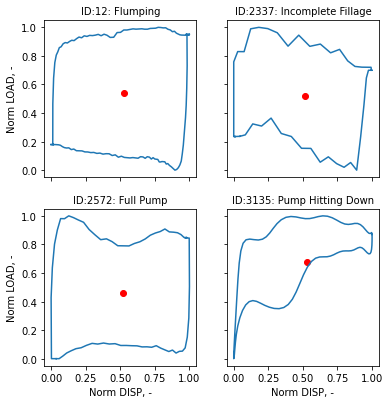

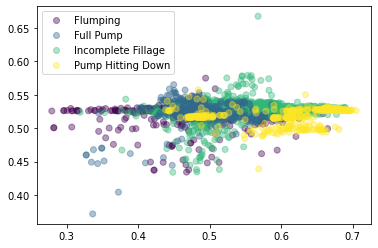

In [22]:
#plot a set of random example cards from each category
import matplotlib.pyplot as plt
  
cardlabels=dyna.label.unique()
fig, axs = plt.subplots(nrows=math.ceil(cardlabels.size/2), ncols=2,
                        sharex=True, sharey=True)
# set labels
plt.setp(axs[-1, :], xlabel='Norm DISP, -')
plt.setp(axs[:, 0], ylabel='Norm LOAD, -')
#plt.setp(axs, xlim=(0.,1.0), ylim=(0.,1.0) )

m = n = 0
nMax = 2
for l in cardlabels:
    idx = dyna[dyna.label==l].sample().index[0]
    axs[m, n].plot(dyna.disp[idx], dyna.load[idx]) 
    axs[m, n].scatter(dyna.mean_disp[idx], dyna.mean_load[idx], c='red') 
    axs[m, n].set_title('ID:'+str(idx)+': '+dyna.label[idx], fontsize = 10)
    n = n + 1
    if (n == nMax):
        n = 0 
        m = m + 1

plt.subplots_adjust(bottom=0.3, top=1.5)
plt.show()
#----------------------------------------------------------------------
# Plot Centroids
from matplotlib.colors import from_levels_and_colors

u, inv = np.unique(dyna.label, return_inverse=True)
cmap, norm = from_levels_and_colors(np.arange(0, len(u)+1)-0.5, 
                                    plt.cm.viridis(np.linspace(0,1,len(u))))
p1 = plt.scatter(dyna.mean_load, dyna.mean_disp, 
                 c=inv, cmap=cmap, norm=norm, alpha=0.4)
plt.legend(p1.legend_elements()[0],u)#, loc='lower right')
plt.show()

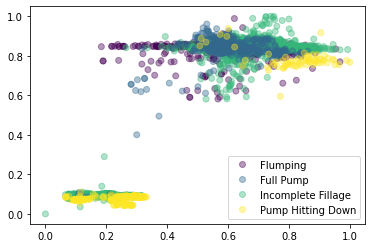

In [23]:
#----------------------------------------------------------------------
# Plot first coefficients
p1 = plt.scatter(dyna.lfftCoeff_0, dyna.dfftCoeff_0, 
                 c=inv, cmap=cmap, norm=norm, alpha=0.4)
plt.legend(p1.legend_elements()[0],u)#, loc='lower right')
plt.show()
#----------------------------------------------------------------------

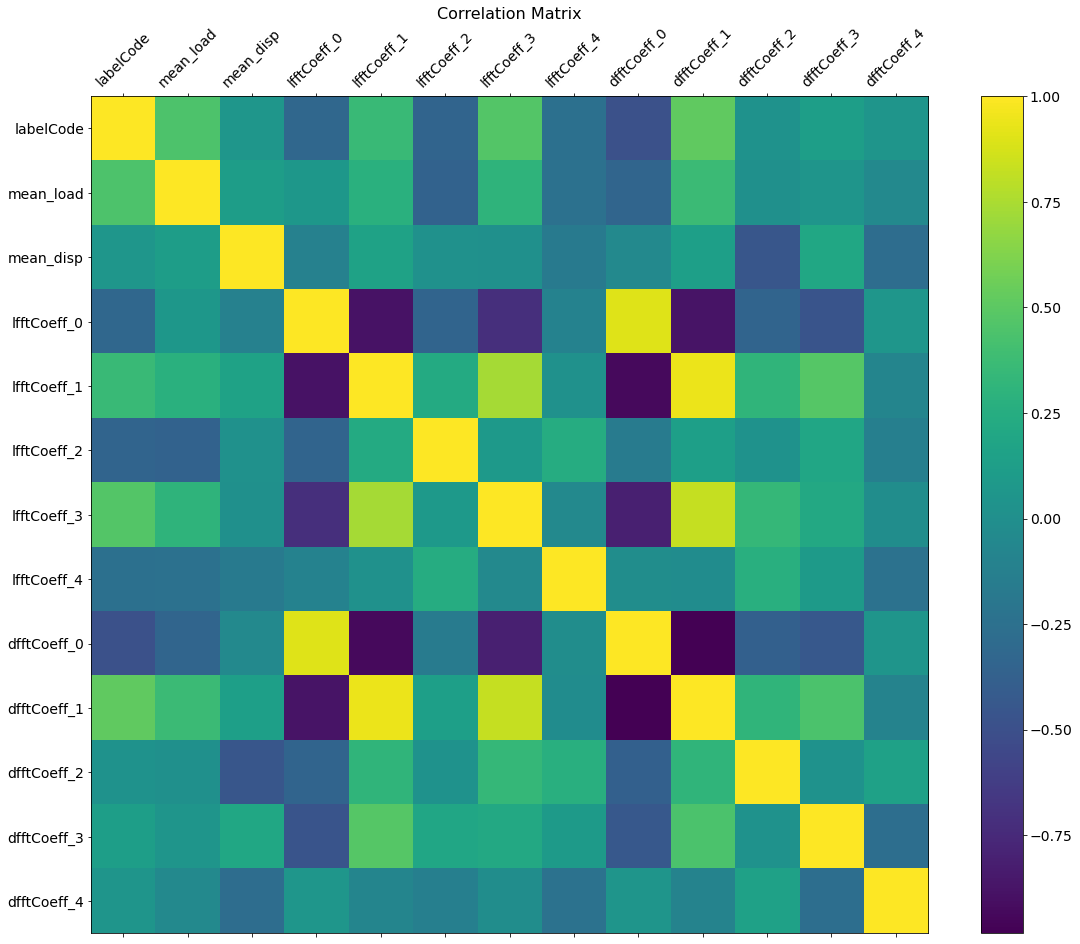

In [24]:
# Corrlation map
f = plt.figure(figsize=(19, 15))
plt.matshow(dyna.corr(), fignum=f.number)
plt.xticks(range(dyna.select_dtypes(['number']).shape[1]), dyna.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(dyna.select_dtypes(['number']).shape[1]), dyna.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [25]:
# Form dataset X- features & y is target
X = dyna[dyna.columns[8:]].to_numpy()
y = dyna.labelCode

# Sub-divide datatest into training and testing: 70 - 30% split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, random_state=1002)

In [27]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

NUMFOLDS = 5
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=1029, max_iter=10000)
res_LR = cross_validate(log_reg, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

In [28]:
# Gaussian Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1011 points : 673


In [29]:
# Support Vector Machine
from sklearn.svm import LinearSVC
svm = LinearSVC(dual=False)
#clf_SVM = cross_val_score(svm, X_train, y_train, cv = 10, scoring='accuracy')
res_SVM = cross_validate(svm, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1029)
#clf_DT = cross_val_score(decision_tree, X_train, y_train, cv = 10, scoring='accuracy')
res_DT = cross_validate(dt, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1029)
#clf_RF = cross_val_score(random_forest, X_train, y_train, cv = 10, scoring='accuracy')
res_RF = cross_validate(rf, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])


# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=1029)
#clf_ET = cross_val_score(extra_tree, X_train, y_train, cv = 10, scoring='accuracy')
res_ET = cross_validate(et, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

# GradientBoosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=1029)
#clf_GB = cross_val_score(gb, X_train, y_train, cv = 10, scoring='accuracy')
res_gb = cross_validate(gb, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[21:53:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [31]:
# XGBoost Classifier
import xgboost as xgb
#y.astype("category")
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
res_xgb = cross_validate(xgb_model, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

[21:54:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:54:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:54:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:54:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

Train: 0.877, Test: 0.846


<AxesSubplot:>

Text(0.5, 1.0, 'Categorical Cross-Entropy Loss')

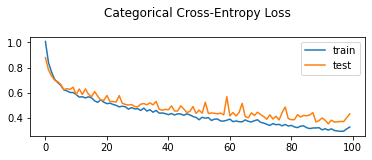

In [30]:
# Artificial Neural network using Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

SPARSE = True
if (SPARSE):
    yy = y
    loss = 'sparse_categorical_crossentropy'
else:
    yy = to_categorical(y)
    loss = 'categorical_crossentropy'
    
X_train, X_test, y_train, y_test = train_test_split(
    X, yy, 
    test_size=0.3, random_state=1002)

nn = Sequential()
nn.add(Dense(units=100, activation='relu', kernel_initializer='he_uniform'))
nn.add(Dense(units=50, activation='relu', kernel_initializer='he_uniform'))
nn.add(Dense(units=4, activation='softmax'))
opt = SGD(learning_rate=0.01, momentum=0.9)
nn.compile(loss=loss,
           optimizer=opt, metrics=['accuracy'])
# fit model
history = nn.fit(X_train, y_train, validation_data=(X_test, y_test),
                 epochs=100, verbose=0)
# evaluate model
_, train_acc = nn.evaluate(X_train, y_train, verbose=0)
_, test_acc = nn.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' %(train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Categorical Cross-Entropy Loss', pad=20)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

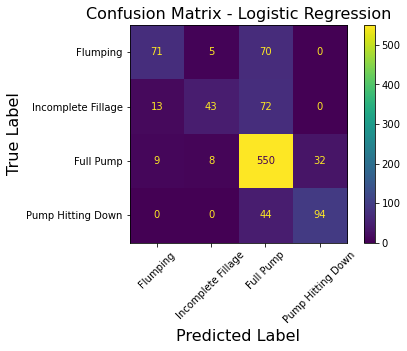

Classification Report for Logistic Regression
                    precision    recall  f1-score   support

          Flumping       0.76      0.49      0.59       146
Incomplete Fillage       0.77      0.34      0.47       128
         Full Pump       0.75      0.92      0.82       599
 Pump Hitting Down       0.75      0.68      0.71       138

          accuracy                           0.75      1011
         macro avg       0.76      0.61      0.65      1011
      weighted avg       0.75      0.75      0.73      1011



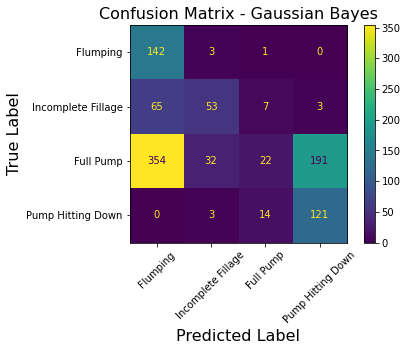

Classification Report for Gaussian Bayes
                    precision    recall  f1-score   support

          Flumping       0.25      0.97      0.40       146
Incomplete Fillage       0.58      0.41      0.48       128
         Full Pump       0.50      0.04      0.07       599
 Pump Hitting Down       0.38      0.88      0.53       138

          accuracy                           0.33      1011
         macro avg       0.43      0.58      0.37      1011
      weighted avg       0.46      0.33      0.23      1011



In [33]:
# Calculate the confusion matrix
#
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def plot_confusion_matrix(model, model_name):
    model.fit(X_train, y_train)
    if (model_name=='Neural Network'): #and (not SPARSE)):
        y_pred = np.argmax(model.predict(X_test), axis=1)
    else:
        y_pred = model.predict(X_test)

    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    #fig, ax = plt.subplots(figsize=(7.5, 7.5))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                                  display_labels=cardlabels)
    disp = disp.plot(xticks_rotation=45)
    
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.title('Confusion Matrix - ' + model_name, fontsize=16)
    plt.show()
    #plt.close(fig)
    
    # print classification report
    print('Classification Report for '+ model_name +'\n'+ 
          classification_report(y_true=y_test, y_pred=y_pred, 
                                target_names=cardlabels))
    

plot_confusion_matrix(log_reg, 'Logistic Regression')
plot_confusion_matrix(gnb, 'Gaussian Bayes')

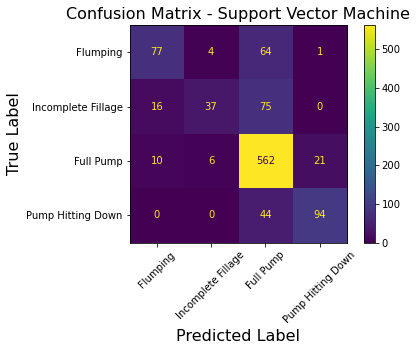

Classification Report for Support Vector Machine
                    precision    recall  f1-score   support

          Flumping       0.75      0.53      0.62       146
Incomplete Fillage       0.79      0.29      0.42       128
         Full Pump       0.75      0.94      0.84       599
 Pump Hitting Down       0.81      0.68      0.74       138

          accuracy                           0.76      1011
         macro avg       0.77      0.61      0.65      1011
      weighted avg       0.77      0.76      0.74      1011



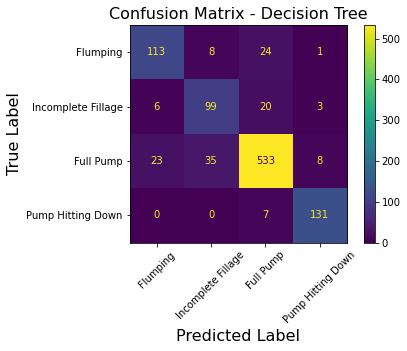

Classification Report for Decision Tree
                    precision    recall  f1-score   support

          Flumping       0.80      0.77      0.78       146
Incomplete Fillage       0.70      0.77      0.73       128
         Full Pump       0.91      0.89      0.90       599
 Pump Hitting Down       0.92      0.95      0.93       138

          accuracy                           0.87      1011
         macro avg       0.83      0.85      0.84      1011
      weighted avg       0.87      0.87      0.87      1011



In [34]:
plot_confusion_matrix(svm, 'Support Vector Machine')
plot_confusion_matrix(dt, 'Decision Tree')

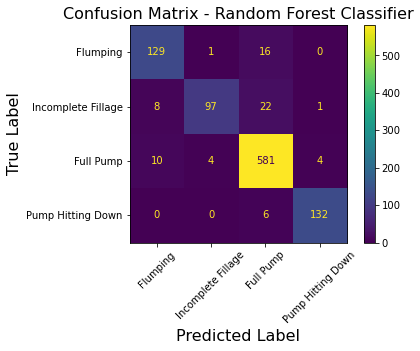

Classification Report for Random Forest Classifier
                    precision    recall  f1-score   support

          Flumping       0.88      0.88      0.88       146
Incomplete Fillage       0.95      0.76      0.84       128
         Full Pump       0.93      0.97      0.95       599
 Pump Hitting Down       0.96      0.96      0.96       138

          accuracy                           0.93      1011
         macro avg       0.93      0.89      0.91      1011
      weighted avg       0.93      0.93      0.93      1011



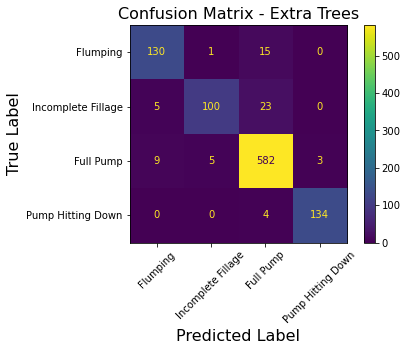

Classification Report for Extra Trees
                    precision    recall  f1-score   support

          Flumping       0.90      0.89      0.90       146
Incomplete Fillage       0.94      0.78      0.85       128
         Full Pump       0.93      0.97      0.95       599
 Pump Hitting Down       0.98      0.97      0.97       138

          accuracy                           0.94      1011
         macro avg       0.94      0.90      0.92      1011
      weighted avg       0.94      0.94      0.93      1011



In [35]:
plot_confusion_matrix(rf, 'Random Forest Classifier')
plot_confusion_matrix(et, 'Extra Trees')

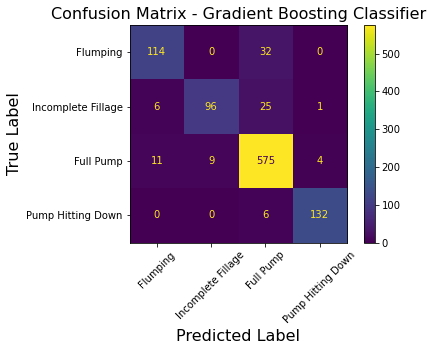

Classification Report for Gradient Boosting Classifier
                    precision    recall  f1-score   support

          Flumping       0.87      0.78      0.82       146
Incomplete Fillage       0.91      0.75      0.82       128
         Full Pump       0.90      0.96      0.93       599
 Pump Hitting Down       0.96      0.96      0.96       138

          accuracy                           0.91      1011
         macro avg       0.91      0.86      0.88      1011
      weighted avg       0.91      0.91      0.91      1011

[22:19:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


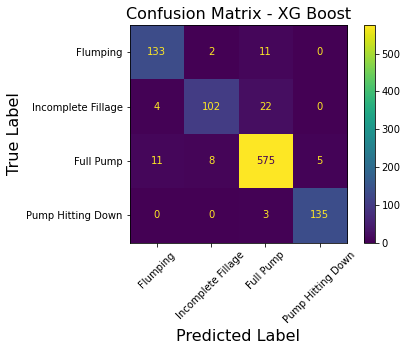

Classification Report for XG Boost
                    precision    recall  f1-score   support

          Flumping       0.90      0.91      0.90       146
Incomplete Fillage       0.91      0.80      0.85       128
         Full Pump       0.94      0.96      0.95       599
 Pump Hitting Down       0.96      0.98      0.97       138

          accuracy                           0.93      1011
         macro avg       0.93      0.91      0.92      1011
      weighted avg       0.93      0.93      0.93      1011



In [36]:
plot_confusion_matrix(gb, 'Gradient Boosting Classifier')
plot_confusion_matrix(xgb_model, 'XG Boost')

74/74 [==============================] - 0s 2ms/step - loss: 0.2878 - accuracy: 0.8978


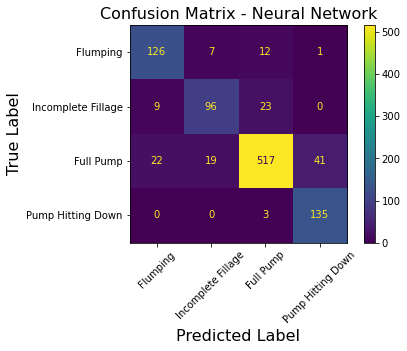

Classification Report for Neural Network
                    precision    recall  f1-score   support

          Flumping       0.80      0.86      0.83       146
Incomplete Fillage       0.79      0.75      0.77       128
         Full Pump       0.93      0.86      0.90       599
 Pump Hitting Down       0.76      0.98      0.86       138

          accuracy                           0.86      1011
         macro avg       0.82      0.86      0.84      1011
      weighted avg       0.87      0.86      0.87      1011



In [37]:
plot_confusion_matrix(nn, 'Neural Network')